# Seq2seq

In [202]:
import random
import numpy as np
import matplotlib.pyplot as plt

import pickle as pkl
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import (
    LSTM, Dense, RepeatVector, TimeDistributed,
    Input, BatchNormalization, multiply, concatenate,
    Flatten, Activation, dot, GRU
)
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
# import pydot as pyd
from keras.utils.vis_utils import plot_model, model_to_dot
# keras.utils.vis_utils.pydot = pyd
import pandas as pd
from keras import backend as K

## Почасовой прогноз

### LSTM

In [135]:
energo = pd.read_csv('data.csv', index_col='Местное время в Красноярске')

In [136]:
target = 'Потребление, МВт*ч'

In [137]:
five_old = energo.iloc[: 24 * 7 * 5][target]
n_five_old = five_old.shape[0]

In [138]:
five_new = energo.iloc[-24 * 7 * 5:][target]
n_five_new = five_new.shape[0]

In [139]:
n_five_old, n_five_new

(840, 840)

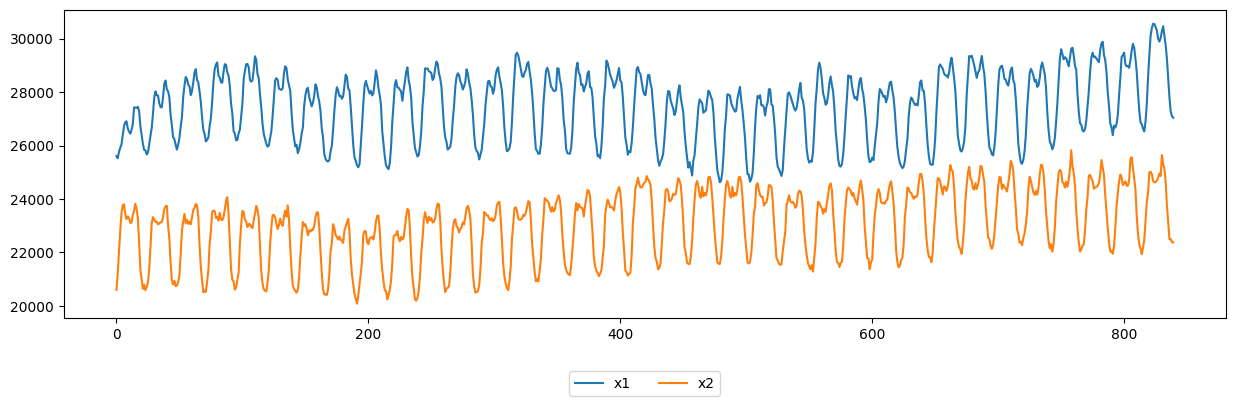

In [140]:
n_ = n_five_new
t = np.linspace(0, 50*np.pi, n_)
# pattern + trend + noise
x1 = five_old # sum([20*np.sin(i*t+np.pi) for i in range(5)]) + 0.01*(t**2) + np.random.normal(0, 6, n_)
x2 = five_new # sum([15*np.sin(2*i*t+np.pi) for i in range(5)]) + 0.5*t + np.random.normal(0, 6, n_)
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1)), x1, label='x1')
plt.plot(range(len(x2)), x2, label='x2')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [141]:
train_ratio = 0.8
train_len = int(train_ratio * t.shape[0])
print(train_len)

672


In [142]:
x_index = np.array(range(len(t)))

In [143]:
x1_trend_param = np.polyfit(x_index[:train_len], x1[:train_len], 2)
x2_trend_param = np.polyfit(x_index[:train_len], x2[:train_len], 1)
print(x1_trend_param)
print(x2_trend_param)

[-2.75009219e-03  1.40243468e+00  2.72644243e+04]
[2.26364802e+00 2.21074955e+04]


In [144]:
x1_trend = (x_index**2)*x1_trend_param[0]+x_index*x1_trend_param[1]+x1_trend_param[2]
x2_trend = x_index*x2_trend_param[0]+x2_trend_param[1]

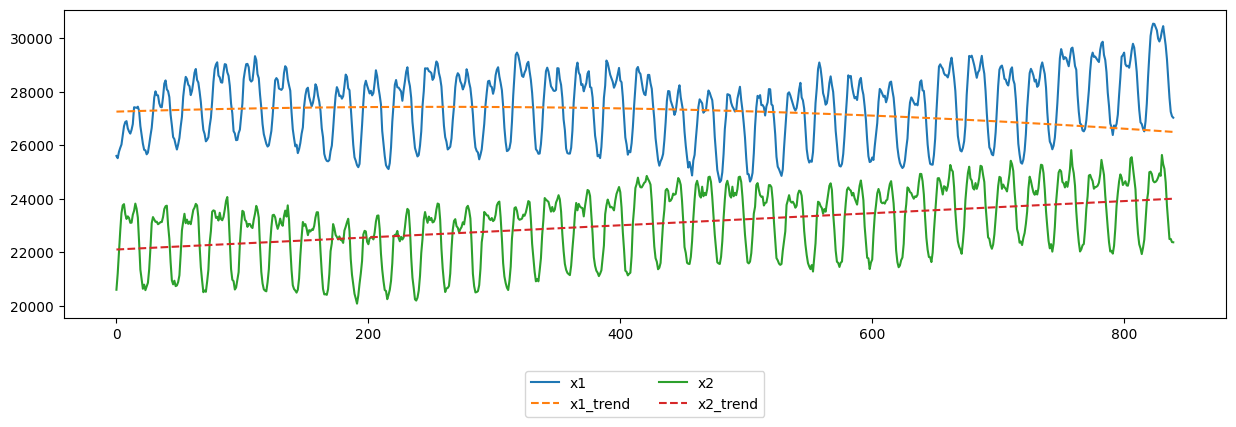

In [145]:
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1)), x1, label='x1')
plt.plot(range(len(x1_trend)), x1_trend, linestyle='--', label='x1_trend')
plt.plot(range(len(x2)), x2, label='x2')
plt.plot(range(len(x2_trend)), x2_trend, linestyle='--', label='x2_trend')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

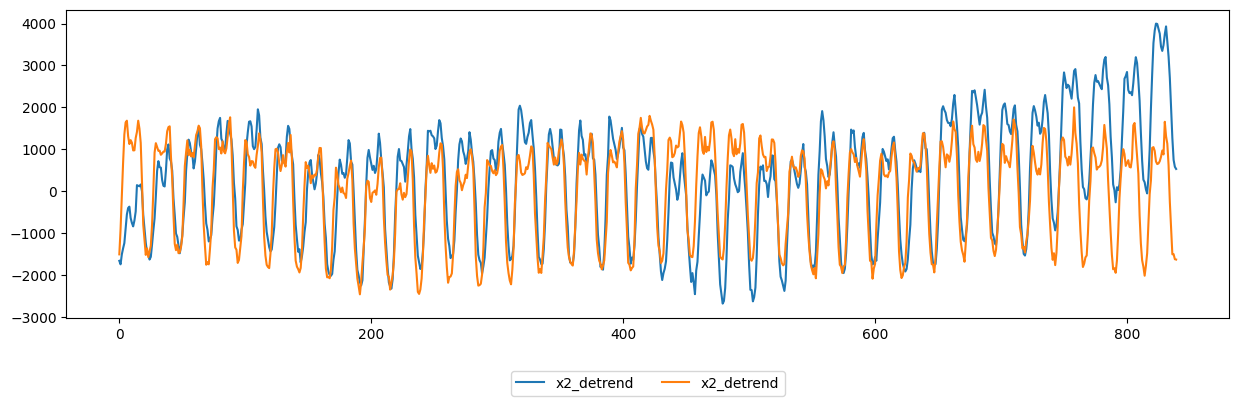

In [146]:
x1_detrend = x1 - x1_trend
x2_detrend = x2 - x2_trend
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1_detrend)), x1_detrend, label='x2_detrend')
plt.plot(range(len(x2_detrend)), x2_detrend, label='x2_detrend')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [147]:
x_lbl = np.column_stack([x1_detrend, x2_detrend, x_index, [1]*train_len+[0]*(len(x_index)-train_len)])
print(x_lbl.shape)
print(x_lbl)

(840, 4)
[[-1.65942428e+03 -1.50449549e+03  0.00000000e+00  1.00000000e+00]
 [-1.74282396e+03 -9.03759142e+02  1.00000000e+00  1.00000000e+00]
 [-1.50621815e+03 -1.00022790e+02  2.00000000e+00  1.00000000e+00]
 ...
 [ 7.46367227e+02 -1.50016889e+03  8.37000000e+02  0.00000000e+00]
 [ 5.82571197e+02 -1.62043254e+03  8.38000000e+02  0.00000000e+00]
 [ 5.31780666e+02 -1.62869618e+03  8.39000000e+02  0.00000000e+00]]


In [148]:
x_train_max = x_lbl[x_lbl[:, 3]==1, :2].max(axis=0)
x_train_max = x_train_max.tolist()+[1]*2  # only normalize for the first 2 columns
print(x_train_max)

[2296.616800615502, 1798.5086894390988, 1, 1]


In [149]:
x_normalize = np.divide(x_lbl, x_train_max)
print(x_normalize)

[[-7.22551658e-01 -8.36523895e-01  0.00000000e+00  1.00000000e+00]
 [-7.58865807e-01 -5.02504740e-01  1.00000000e+00  1.00000000e+00]
 [-6.55842170e-01 -5.56142933e-02  2.00000000e+00  1.00000000e+00]
 ...
 [ 3.24985529e-01 -8.34118231e-01  8.37000000e+02  0.00000000e+00]
 [ 2.53664955e-01 -9.00986770e-01  8.38000000e+02  0.00000000e+00]
 [ 2.31549585e-01 -9.05581493e-01  8.39000000e+02  0.00000000e+00]]


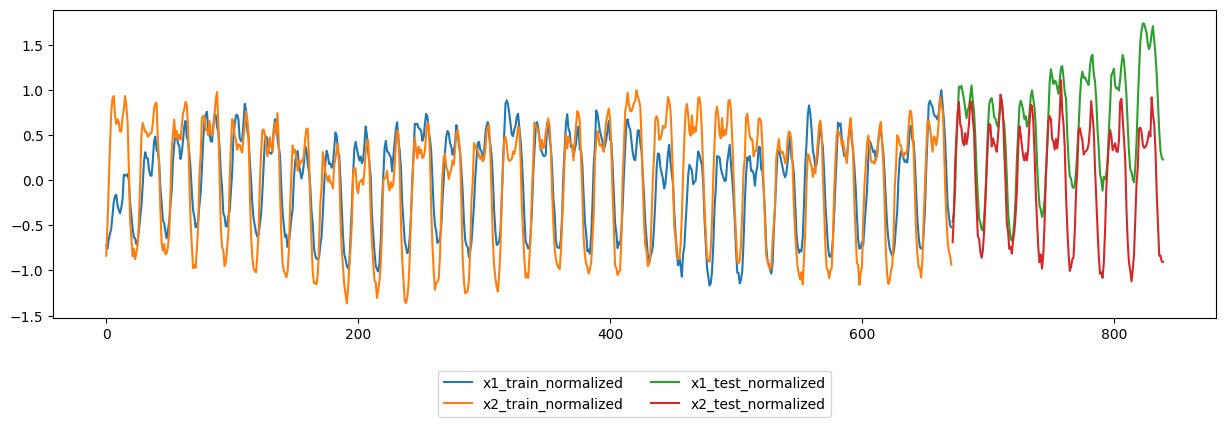

In [150]:
plt.figure(figsize=(15, 4))
plt.plot(range(train_len), x_normalize[:train_len, 0], label='x1_train_normalized')
plt.plot(range(train_len), x_normalize[:train_len, 1], label='x2_train_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 0], label='x1_test_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 1], label='x2_test_normalized')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [151]:
def truncate(x, feature_cols=range(3), target_cols=range(3), label_col=3, train_len=100, test_len=20):
    in_, out_, lbl = [], [], []
    for i in range(len(x)-train_len-test_len+1):
        in_.append(x[i:(i+train_len), feature_cols].tolist())
        out_.append(x[(i+train_len):(i+train_len+test_len), target_cols].tolist())
        lbl.append(x[i+train_len, label_col])
    return np.array(in_), np.array(out_), np.array(lbl)
X_in, X_out, lbl = truncate(x_normalize, feature_cols=range(3), target_cols=range(3), 
                            label_col=3, train_len=200, test_len=20)
print(X_in.shape, X_out.shape, lbl.shape)

(621, 200, 3) (621, 20, 3) (621,)


In [152]:
X_input_train = X_in[np.where(lbl==1)]
X_output_train = X_out[np.where(lbl==1)]
X_input_test = X_in[np.where(lbl==0)]
X_output_test = X_out[np.where(lbl==0)]
print(X_input_train.shape, X_output_train.shape)
print(X_input_test.shape, X_output_test.shape)

(472, 200, 3) (472, 20, 3)
(149, 200, 3) (149, 20, 3)


In [153]:
n_hidden = 100

In [154]:
input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))
print(input_train)
print(output_train)

KerasTensor(type_spec=TensorSpec(shape=(None, 200, 2), dtype=tf.float32, name='input_9'), name='input_9', description="created by layer 'input_9'")
KerasTensor(type_spec=TensorSpec(shape=(None, 20, 2), dtype=tf.float32, name='input_10'), name='input_10', description="created by layer 'input_10'")


In [155]:
encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
 n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
 return_sequences=False, return_state=True)(input_train)
print(encoder_last_h1)
print(encoder_last_h2)
print(encoder_last_c)

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm_8/strided_slice_3:0', description="created by layer 'lstm_8'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm_8/while:4', description="created by layer 'lstm_8'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm_8/while:5', description="created by layer 'lstm_8'")


In [156]:
encoder_last_h1 = BatchNormalization(momentum=0.6)(encoder_last_h1)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

In [157]:
decoder = RepeatVector(output_train.shape[1])(encoder_last_h1)
decoder = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_state=False, return_sequences=True)(
    decoder, initial_state=[encoder_last_h1, encoder_last_c])
print(decoder)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='lstm_9/transpose_1:0', description="created by layer 'lstm_9'")


In [158]:
out = TimeDistributed(Dense(output_train.shape[2]))(decoder)
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 2), dtype=tf.float32, name=None), name='time_distributed_4/Reshape_1:0', description="created by layer 'time_distributed_4'")


In [159]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [160]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(learning_rate=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae', coeff_determination])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 200, 2)]     0           []                               
                                                                                                  
 lstm_8 (LSTM)                  [(None, 100),        41200       ['input_9[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 100)         400         ['lstm_8[0][0]']                 
 rmalization)                                                                               

In [161]:
epc = 100
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model.fit(X_input_train[:, :, :2], X_output_train[:, :, :2], validation_split=0.2, 
                    epochs=epc, verbose=0, callbacks=[es], 
                    batch_size=100)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']
 
# model.save('model_forecasting_seq2seq.h5')

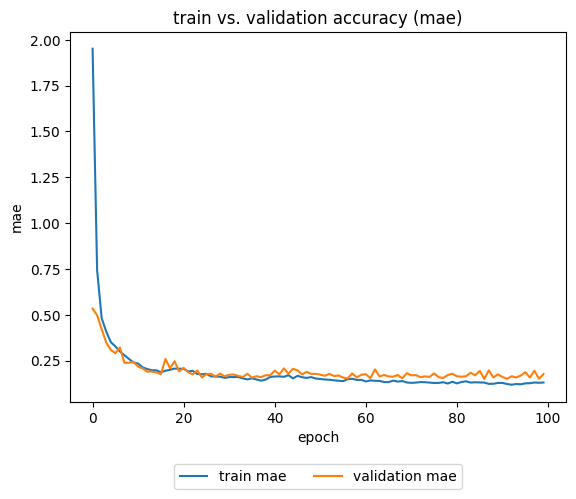

In [162]:
plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [163]:
train_pred_detrend = model.predict(X_input_train[:, :, :2])*x_train_max[:2]
test_pred_detrend = model.predict(X_input_test[:, :, :2])*x_train_max[:2]
print(train_pred_detrend.shape, test_pred_detrend.shape)
train_true_detrend = X_output_train[:, :, :2]*x_train_max[:2]
test_true_detrend = X_output_test[:, :, :2]*x_train_max[:2]
print(train_true_detrend.shape, test_true_detrend.shape)

5/5 [==============================] - 0s 57ms/step
(472, 20, 2) (149, 20, 2)
(472, 20, 2) (149, 20, 2)


In [164]:
train_pred_detrend = np.concatenate([train_pred_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_pred_detrend = np.concatenate([test_pred_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)
train_true_detrend = np.concatenate([train_true_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_true_detrend = np.concatenate([test_true_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

(472, 20, 3) (149, 20, 3)
(472, 20, 3) (149, 20, 3)


In [165]:
data_final = dict()
for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend], 
                  ['train_pred', 'train_true', 'test_pred', 'test_true']):
    dt_x1 = dt[:, :, 0] + (dt[:, :, 2]**2)*x1_trend_param[0] + dt[:, :, 2]*x1_trend_param[1] + x1_trend_param[2]
    dt_x2 = dt[:, :, 1] + dt[:, :, 2]*x2_trend_param[0] + x2_trend_param[1]
    data_final[lb] = np.concatenate(
        [np.expand_dims(dt_x1, axis=2), np.expand_dims(dt_x2, axis=2)], axis=2)
    print(lb+': {}'.format(data_final[lb].shape))

train_pred: (472, 20, 2)
train_true: (472, 20, 2)
test_pred: (149, 20, 2)
test_true: (149, 20, 2)


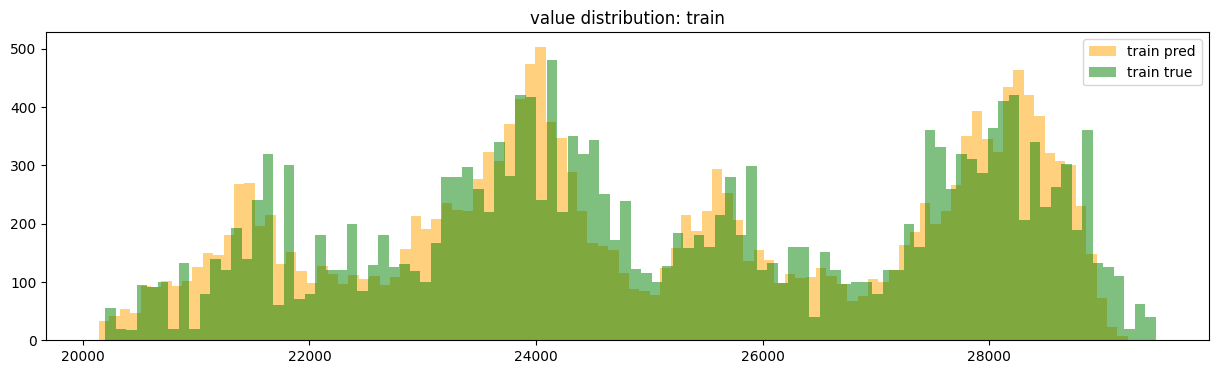

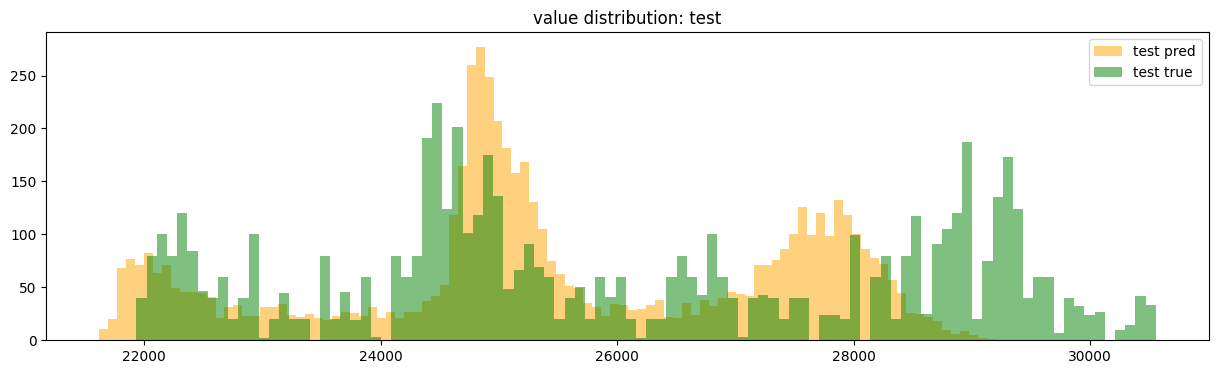

In [166]:
for lb in ['train', 'test']:
    plt.figure(figsize=(15, 4))
    plt.hist(data_final[lb+'_pred'].flatten(), bins=100, color='orange', alpha=0.5, label=lb+' pred')
    plt.hist(data_final[lb+'_true'].flatten(), bins=100, color='green', alpha=0.5, label=lb+' true')
    plt.legend()
    plt.title('value distribution: '+lb)
    plt.show()

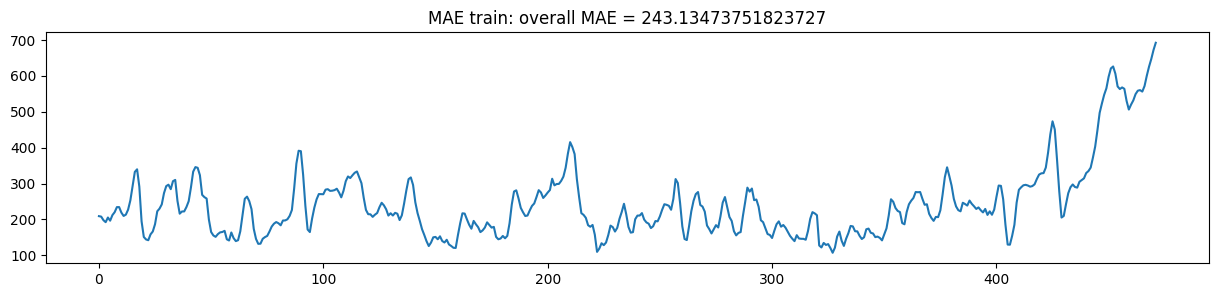

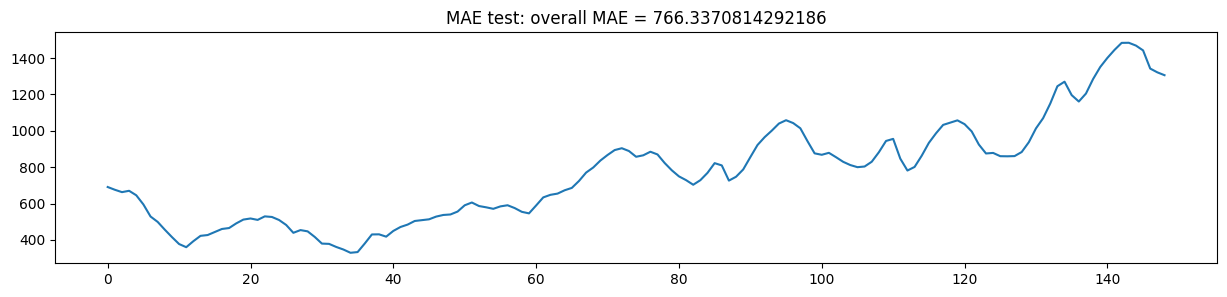

In [167]:
for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show()

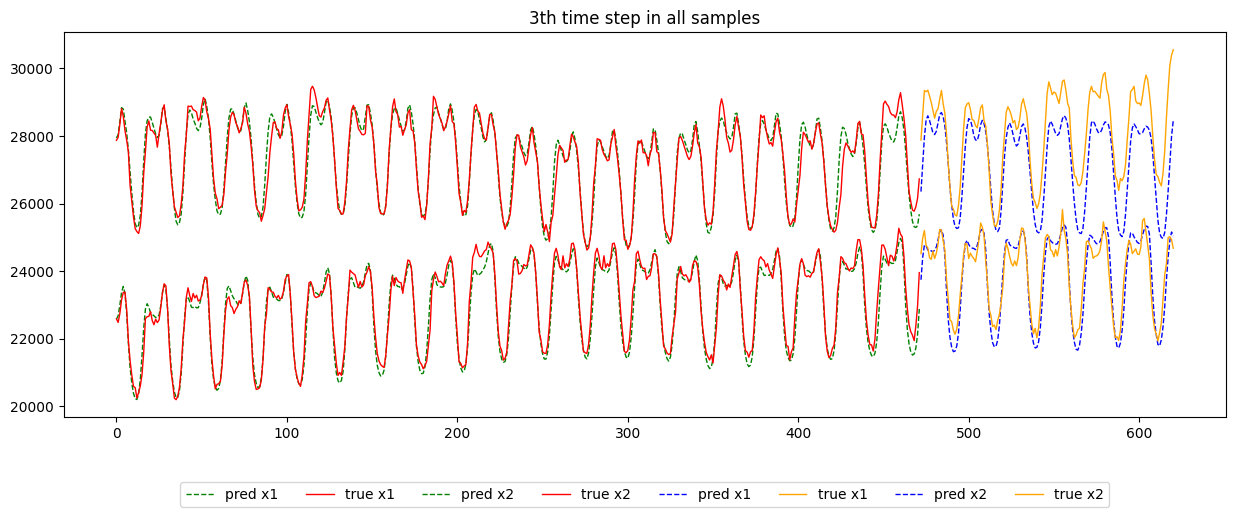

In [168]:
ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
plt.figure(figsize=(15, 5))
train_start_t = 0
test_start_t = data_final['train_pred'].shape[0]
for lb, tm, clrs in zip(['train', 'test'], [train_start_t, test_start_t], [['green', 'red'], ['blue', 'orange']]):
    for i, x_lbl in zip([0, 1], ['x1', 'x2']):
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_pred'][:, ith_timestep, i], 
                 linestyle='--', linewidth=1, color=clrs[0], label='pred '+x_lbl)
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_true'][:, ith_timestep, i], 
                 linestyle='-', linewidth=1, color=clrs[1], label='true '+x_lbl)
    
plt.title('{}th time step in all samples'.format(ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=8)
plt.show()

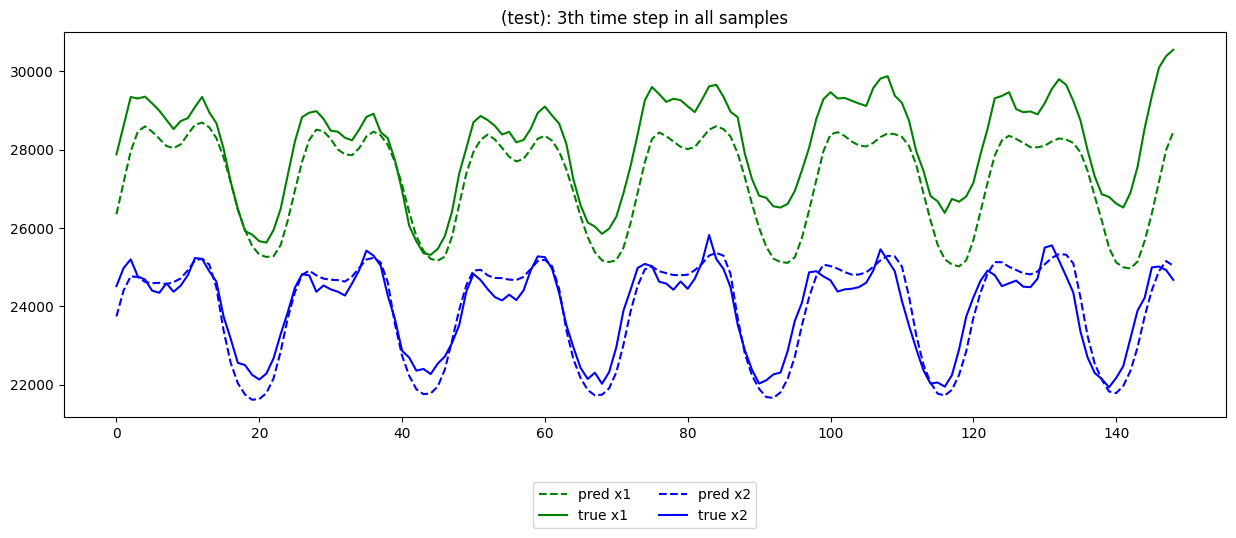

In [169]:
lb = 'test'
plt.figure(figsize=(15, 5))
for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
    plt.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='--', color=clr, label='pred '+x_lbl)
    plt.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
plt.title('({}): {}th time step in all samples'.format(lb, ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

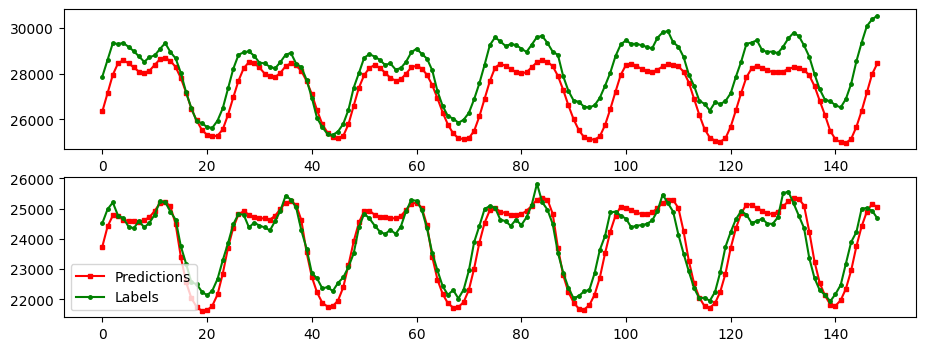

In [198]:
plt.figure(figsize=(11, 4))
plt.subplot(2, 1, 1)
plt.plot(data_final['test_pred'][:, ith_timestep, 0], color='red', label='Predictions', marker='s', ms=3)
plt.plot(data_final['test_true'][:, ith_timestep, 0], color='green', label='Labels', marker='.', ms=5)
plt.subplot(2, 1, 2)
plt.plot(data_final['test_pred'][:, ith_timestep, 1], color='red', label='Predictions', marker='s', ms=3)
plt.plot(data_final['test_true'][:, ith_timestep, 1], color='green', label='Labels', marker='.', ms=5)
plt.legend()
plt.show()

In [199]:
all_mae = {}
all_r2 = {}

In [200]:
all_r2['train_hourly_1'] = history.history['coeff_determination'][-1]
all_r2['val_hourly_1'] = history.history['val_coeff_determination'][-1]
all_mae['train_hourly_1'] = history.history['mae'][-1]
all_mae['val_hourly_1'] = history.history['val_mae'][-1]

### GRU

In [225]:
encoder_last_h1, encoder_last_c = GRU(
 n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
 return_sequences=False, return_state=True)(input_train)
print(encoder_last_h1)
# print(encoder_last_h2)
print(encoder_last_c)

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='gru_12/strided_slice_3:0', description="created by layer 'gru_12'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='gru_12/while:4', description="created by layer 'gru_12'")


In [226]:
encoder_last_h1 = BatchNormalization(momentum=0.6)(encoder_last_h1)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

In [227]:
decoder = RepeatVector(output_train.shape[1])(encoder_last_h1)
decoder = GRU(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_state=False, return_sequences=True)(
    decoder, initial_state=encoder_last_c)
print(decoder)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='gru_13/transpose_1:0', description="created by layer 'gru_13'")


In [228]:
out = TimeDistributed(Dense(output_train.shape[2]))(decoder)
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 2), dtype=tf.float32, name=None), name='time_distributed_6/Reshape_1:0', description="created by layer 'time_distributed_6'")


In [229]:
model_ = Model(inputs=input_train, outputs=out)
opt = Adam(learning_rate=0.01, clipnorm=1)
model_.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae', coeff_determination])
# model.summary()

In [230]:
epc = 100
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history_ = model_.fit(X_input_train[:, :, :2], X_output_train[:, :, :2], validation_split=0.2, 
                    epochs=epc, verbose=0, callbacks=[es], 
                    batch_size=100)
train_mae = history_.history['mae']
valid_mae = history_.history['val_mae']
 
# model.save('model_forecasting_seq2seq.h5')

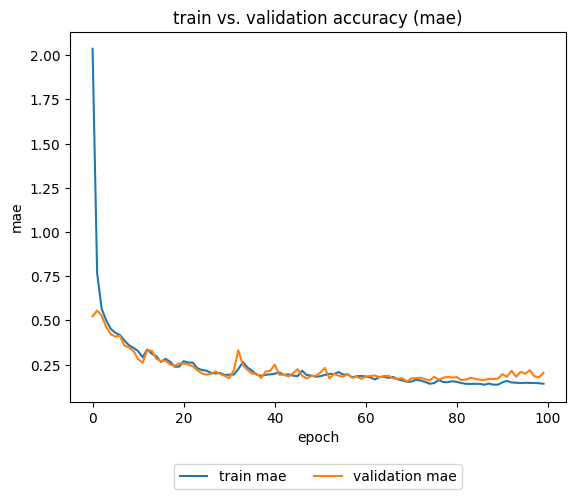

In [231]:
plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [232]:
train_pred_detrend = model.predict(X_input_train[:, :, :2])*x_train_max[:2]
test_pred_detrend = model.predict(X_input_test[:, :, :2])*x_train_max[:2]
print(train_pred_detrend.shape, test_pred_detrend.shape)
train_true_detrend = X_output_train[:, :, :2]*x_train_max[:2]
test_true_detrend = X_output_test[:, :, :2]*x_train_max[:2]
print(train_true_detrend.shape, test_true_detrend.shape)

5/5 [==============================] - 0s 77ms/step
(472, 20, 2) (149, 20, 2)
(472, 20, 2) (149, 20, 2)


In [233]:
train_pred_detrend = np.concatenate([train_pred_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_pred_detrend = np.concatenate([test_pred_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)
train_true_detrend = np.concatenate([train_true_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_true_detrend = np.concatenate([test_true_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

(472, 20, 3) (149, 20, 3)
(472, 20, 3) (149, 20, 3)


In [234]:
data_final = dict()
for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend], 
                  ['train_pred', 'train_true', 'test_pred', 'test_true']):
    dt_x1 = dt[:, :, 0] + (dt[:, :, 2]**2)*x1_trend_param[0] + dt[:, :, 2]*x1_trend_param[1] + x1_trend_param[2]
    dt_x2 = dt[:, :, 1] + dt[:, :, 2]*x2_trend_param[0] + x2_trend_param[1]
    data_final[lb] = np.concatenate(
        [np.expand_dims(dt_x1, axis=2), np.expand_dims(dt_x2, axis=2)], axis=2)
    print(lb+': {}'.format(data_final[lb].shape))

train_pred: (472, 20, 2)
train_true: (472, 20, 2)
test_pred: (149, 20, 2)
test_true: (149, 20, 2)


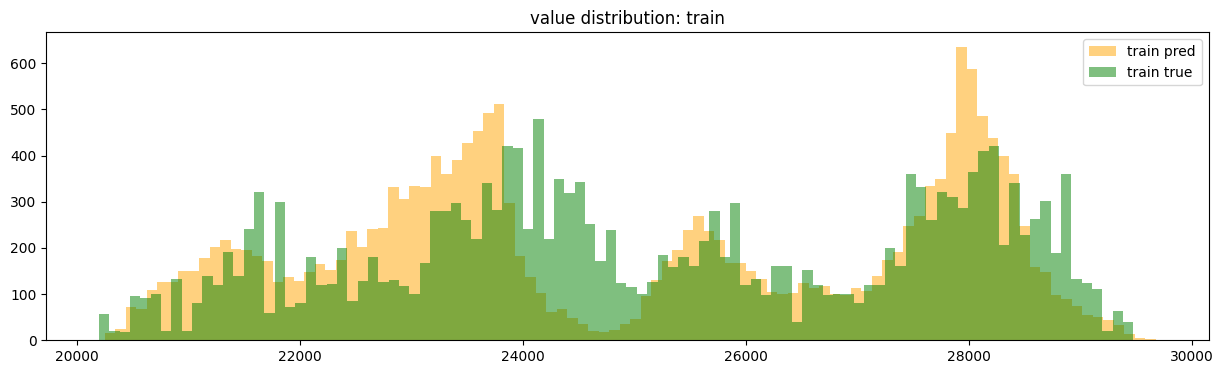

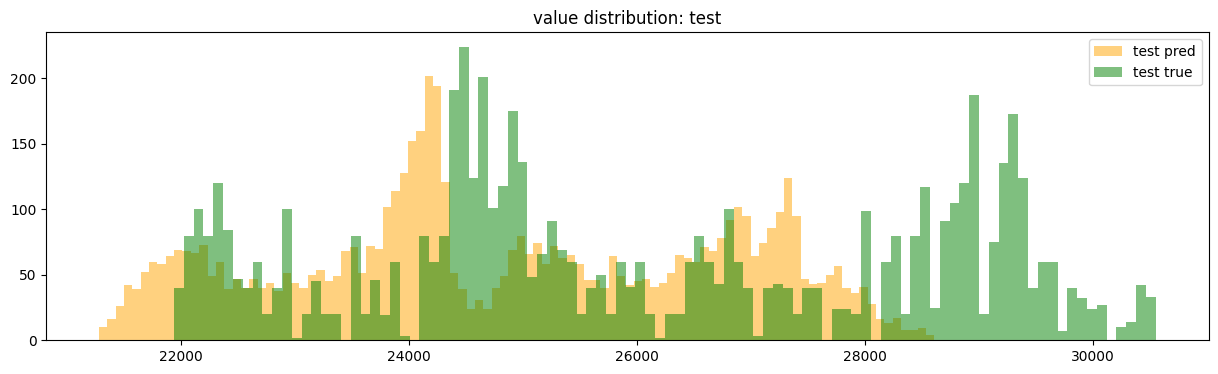

In [235]:
for lb in ['train', 'test']:
    plt.figure(figsize=(15, 4))
    plt.hist(data_final[lb+'_pred'].flatten(), bins=100, color='orange', alpha=0.5, label=lb+' pred')
    plt.hist(data_final[lb+'_true'].flatten(), bins=100, color='green', alpha=0.5, label=lb+' true')
    plt.legend()
    plt.title('value distribution: '+lb)
    plt.show()

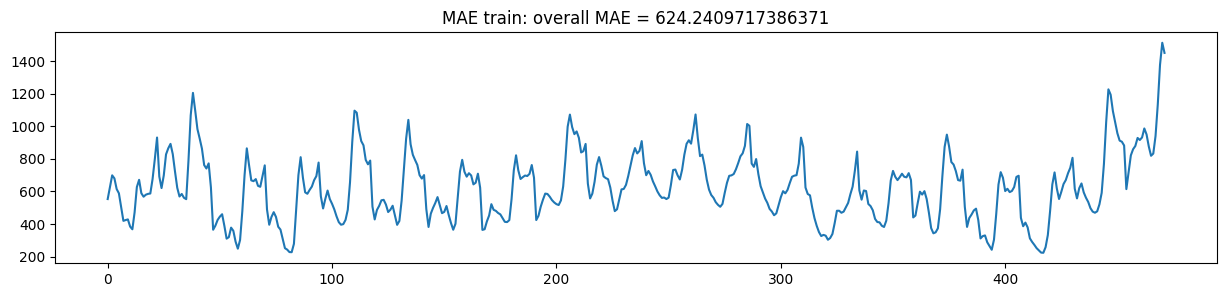

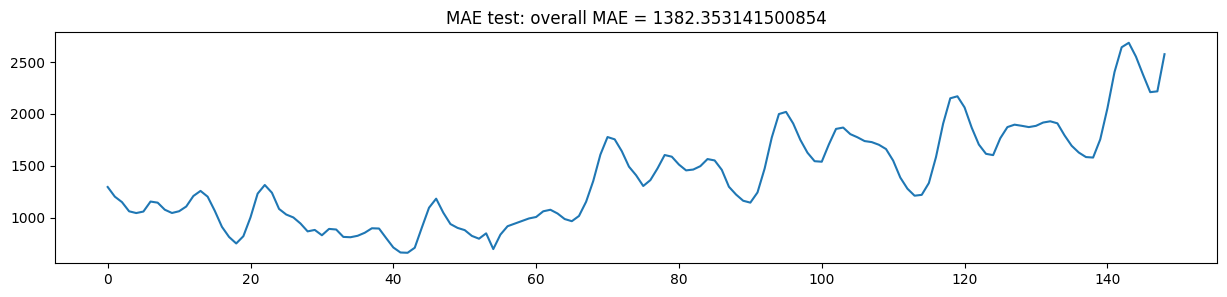

In [236]:
for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show()

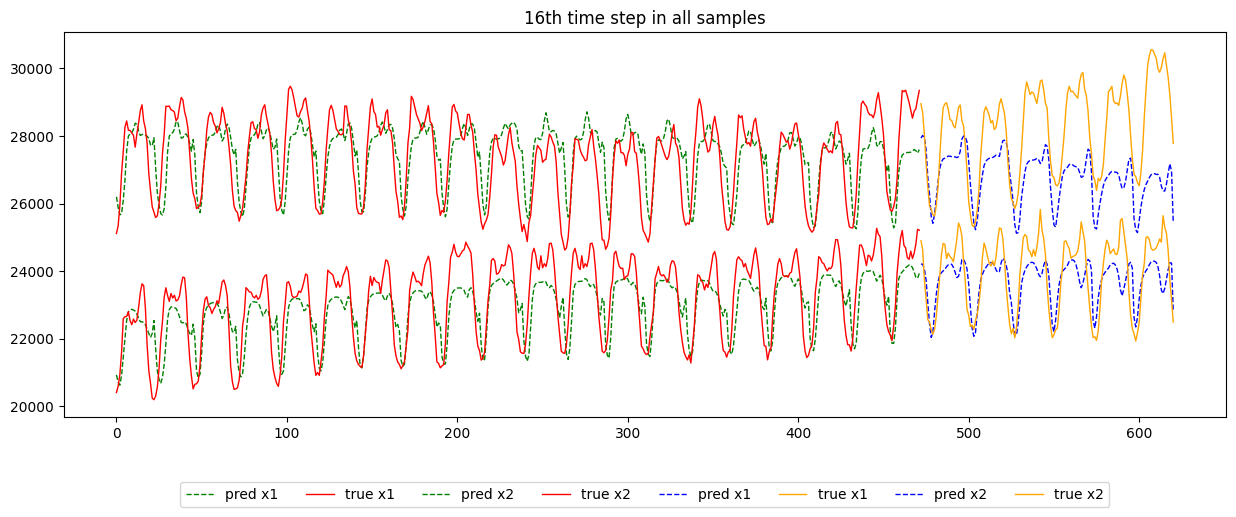

In [237]:
ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
plt.figure(figsize=(15, 5))
train_start_t = 0
test_start_t = data_final['train_pred'].shape[0]
for lb, tm, clrs in zip(['train', 'test'], [train_start_t, test_start_t], [['green', 'red'], ['blue', 'orange']]):
    for i, x_lbl in zip([0, 1], ['x1', 'x2']):
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_pred'][:, ith_timestep, i], 
                 linestyle='--', linewidth=1, color=clrs[0], label='pred '+x_lbl)
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_true'][:, ith_timestep, i], 
                 linestyle='-', linewidth=1, color=clrs[1], label='true '+x_lbl)
    
plt.title('{}th time step in all samples'.format(ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=8)
plt.show()

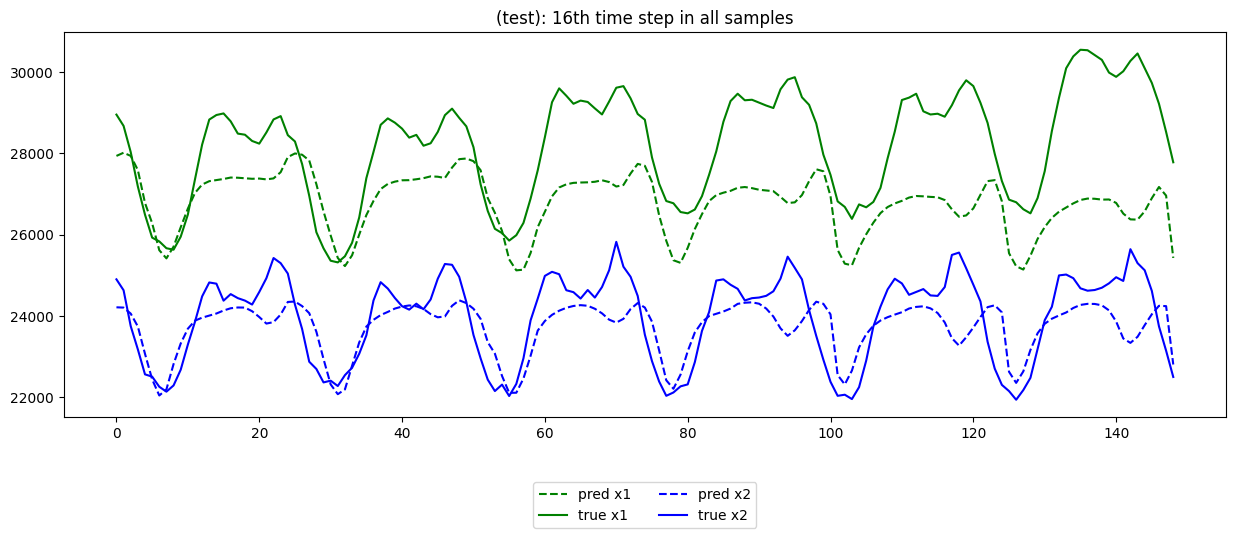

In [238]:
lb = 'test'
plt.figure(figsize=(15, 5))
for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
    plt.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='--', color=clr, label='pred '+x_lbl)
    plt.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
plt.title('({}): {}th time step in all samples'.format(lb, ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

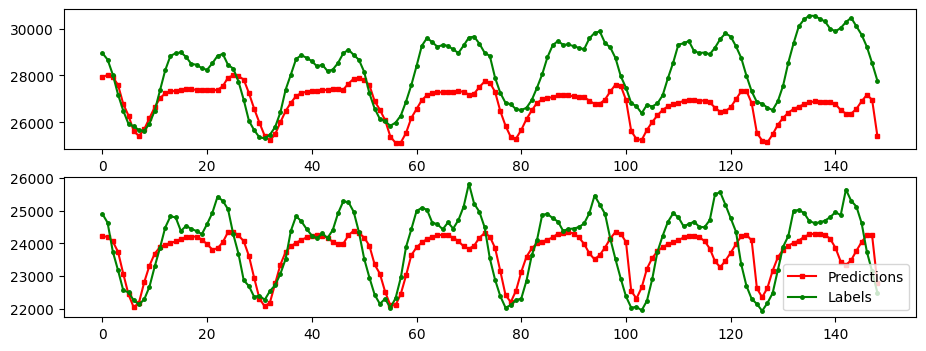

In [239]:
plt.figure(figsize=(11, 4))
plt.subplot(2, 1, 1)
plt.plot(data_final['test_pred'][:, ith_timestep, 0], color='red', label='Predictions', marker='s', ms=3)
plt.plot(data_final['test_true'][:, ith_timestep, 0], color='green', label='Labels', marker='.', ms=5)
plt.subplot(2, 1, 2)
plt.plot(data_final['test_pred'][:, ith_timestep, 1], color='red', label='Predictions', marker='s', ms=3)
plt.plot(data_final['test_true'][:, ith_timestep, 1], color='green', label='Labels', marker='.', ms=5)
plt.legend()
plt.show()

In [244]:
all_r2['train_hourly_2'] = history_.history['coeff_determination'][-1]
all_r2['val_hourly_2'] = history_.history['val_coeff_determination'][-1]
all_mae['train_hourly_2'] = history_.history['mae'][-1]
all_mae['val_hourly_2'] = history_.history['val_mae'][-1]

### Сравнение

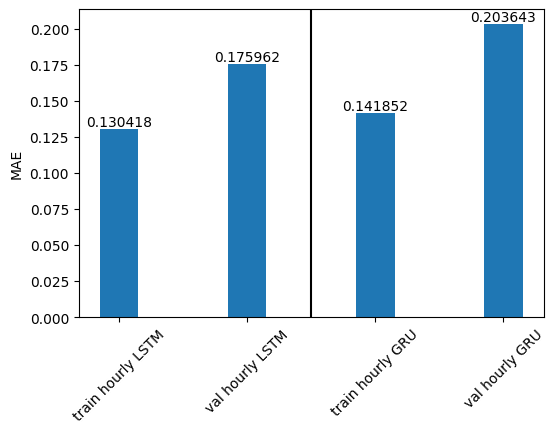

In [246]:
x = np.arange(len(all_mae))
width = 0.3
y = all_mae.values()
labels = [i.replace('_', ' ').replace('1', 'LSTM').replace('2', 'GRU') for i in all_mae.keys()]

plt.figure(figsize=(6, 4))
bar1 = plt.bar(x, y, width)
plt.bar_label(bar1)
plt.xticks(ticks=x, labels=labels, rotation=45)
plt.ylabel(f'MAE')
plt.axvline(x=1.5, color='black')
plt.show()

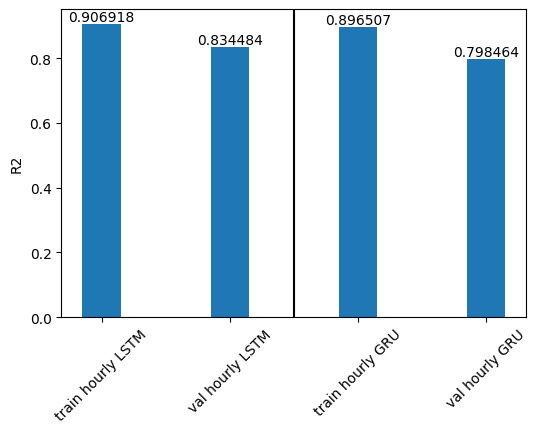

In [247]:
x = np.arange(len(all_r2))
width = 0.3
y = all_r2.values()
labels = [i.replace('_', ' ').replace('1', 'LSTM').replace('2', 'GRU') for i in all_r2.keys()]

plt.figure(figsize=(6, 4))
bar1 = plt.bar(x, y, width)
plt.bar_label(bar1)
plt.xticks(ticks=x, labels=labels, rotation=45)
plt.ylabel(f'R2')
plt.axvline(x=1.5, color='black')
plt.show()

## Посуточный прогноз

### LSTM

In [429]:
target = 'Потребление, МВт*ч'
names = [target]

In [430]:
days = len(energo[target])
hours = days // 24

In [431]:
d = {i: [j.mean() for j in np.array(energo[i])[:24*hours].reshape((hours, 24))] for i in names}

In [432]:
energo_d = pd.DataFrame(d)
energo_d.shape

(290, 1)

In [433]:
month_old = energo_d.iloc[:120][target]
n_month_old = month_old.shape[0]

In [434]:
month_new = energo_d.iloc[-120:][target]
n_month_new = month_new.shape[0]

In [435]:
n_month_old, n_month_new

(120, 120)

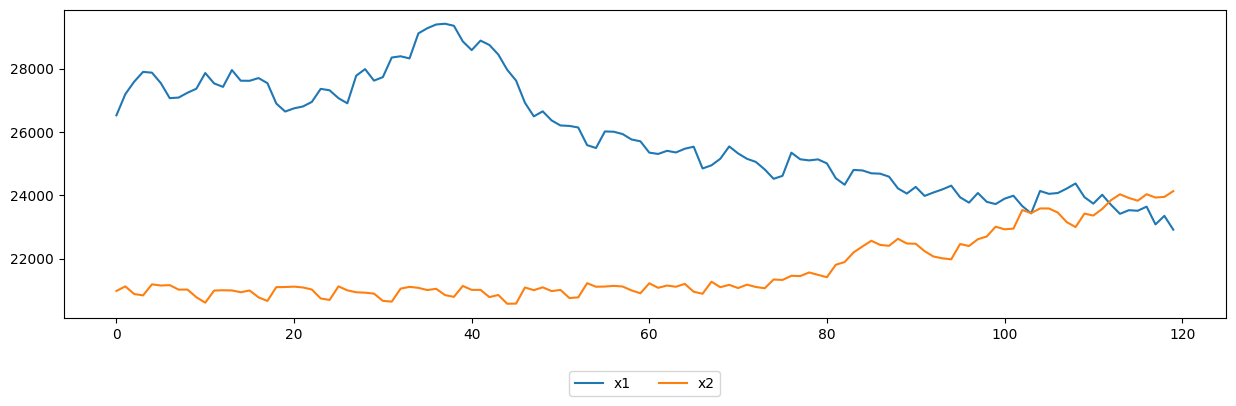

In [436]:
n_ = n_month_new
t = np.linspace(0, 50*np.pi, n_)
# pattern + trend + noise
x1 = month_old # sum([20*np.sin(i*t+np.pi) for i in range(5)]) + 0.01*(t**2) + np.random.normal(0, 6, n_)
x2 = month_new # sum([15*np.sin(2*i*t+np.pi) for i in range(5)]) + 0.5*t + np.random.normal(0, 6, n_)
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1)), x1, label='x1')
plt.plot(range(len(x2)), x2, label='x2')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [437]:
train_ratio = 0.6
train_len = int(train_ratio * t.shape[0])
print(train_len)

72


In [438]:
x_index = np.array(range(len(t)))

In [439]:
x1_trend_param = np.polyfit(x_index[:train_len], x1[:train_len], 2)
x2_trend_param = np.polyfit(x_index[:train_len], x2[:train_len], 1)
print(x1_trend_param)
print(x2_trend_param)

[-1.75157844e+00  9.11252920e+01  2.67817497e+04]
[1.86036079e+00 2.09157882e+04]


C:\Users\nolt2\AppData\Local\Temp\ipykernel_676\2701995472.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  x2_trend_param = np.polyfit(x_index[:train_len], x2[:train_len], 1)


In [440]:
x1_trend = (x_index**2)*x1_trend_param[0]+x_index*x1_trend_param[1]+x1_trend_param[2]
x2_trend = x_index*x2_trend_param[0]+x2_trend_param[1]

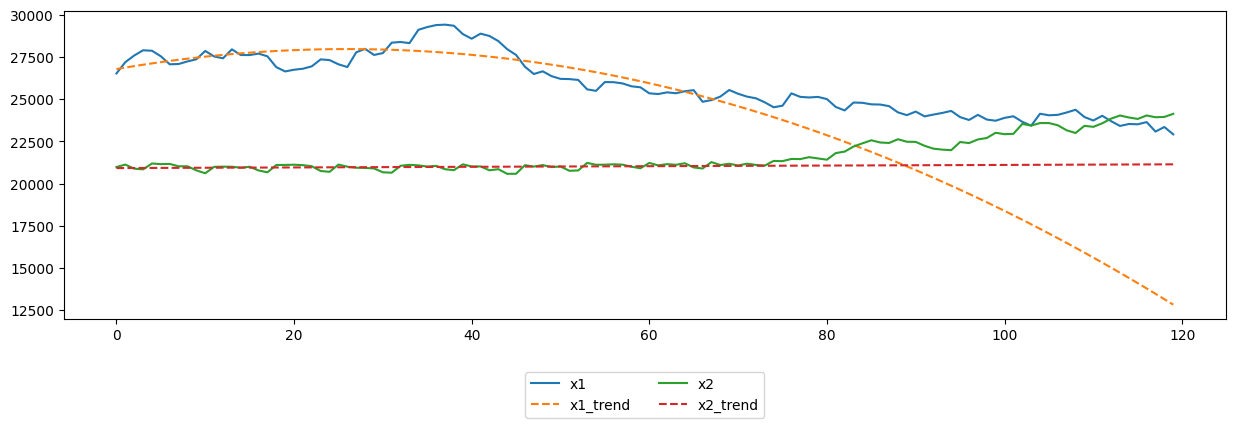

In [441]:
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1)), x1, label='x1')
plt.plot(range(len(x1_trend)), x1_trend, linestyle='--', label='x1_trend')
plt.plot(range(len(x2)), x2, label='x2')
plt.plot(range(len(x2_trend)), x2_trend, linestyle='--', label='x2_trend')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

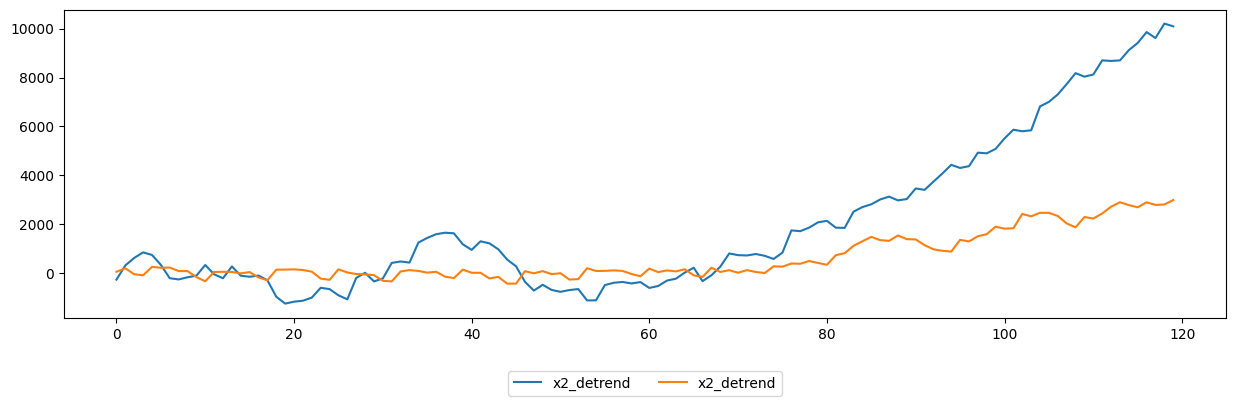

In [442]:
x1_detrend = x1 - x1_trend
x2_detrend = x2 - x2_trend
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1_detrend)), x1_detrend, label='x2_detrend')
plt.plot(range(len(x2_detrend)), x2_detrend, label='x2_detrend')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [443]:
x_lbl = np.column_stack([x1_detrend, x2_detrend, x_index, [1]*train_len+[0]*(len(x_index)-train_len)])
print(x_lbl.shape)
# print(x_lbl)

(120, 4)


In [444]:
x_train_max = x_lbl[x_lbl[:, 3]==1, :2].max(axis=0)
x_train_max = x_train_max.tolist()+[1]*2  # only normalize for the first 2 columns
print(x_train_max)

[1658.442010122566, 263.0203465210361, 1, 1]


In [445]:
x_normalize = np.divide(x_lbl, x_train_max)
# print(x_normalize)

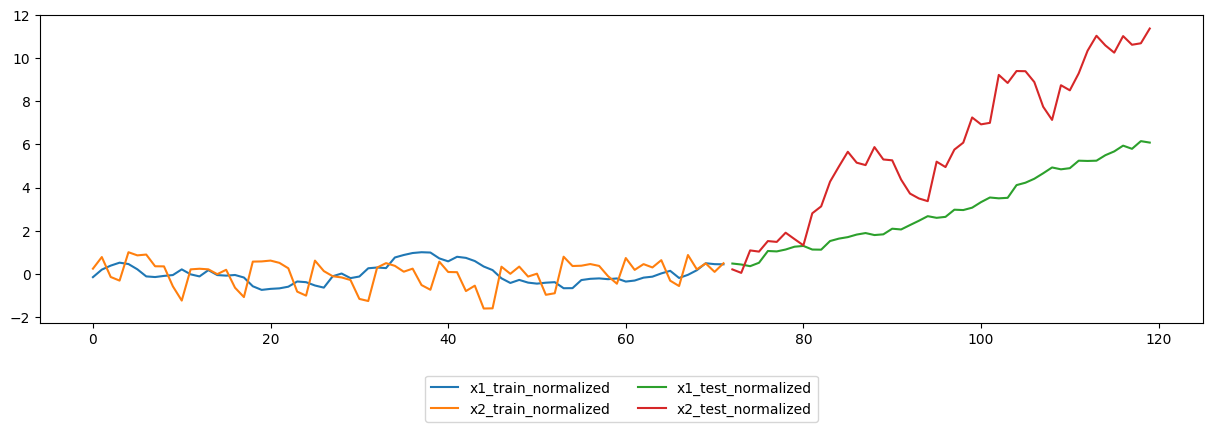

In [446]:
plt.figure(figsize=(15, 4))
plt.plot(range(train_len), x_normalize[:train_len, 0], label='x1_train_normalized')
plt.plot(range(train_len), x_normalize[:train_len, 1], label='x2_train_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 0], label='x1_test_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 1], label='x2_test_normalized')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [447]:
X_in, X_out, lbl = truncate(x_normalize, feature_cols=range(3), target_cols=range(3), 
                            label_col=3, train_len=40, test_len=30)
print(X_in.shape, X_out.shape, lbl.shape)

(51, 40, 3) (51, 30, 3) (51,)


In [448]:
X_input_train = X_in[np.where(lbl==1)]
X_output_train = X_out[np.where(lbl==1)]
X_input_test = X_in[np.where(lbl==0)]
X_output_test = X_out[np.where(lbl==0)]
print(X_input_train.shape, X_output_train.shape)
print(X_input_test.shape, X_output_test.shape)

(32, 40, 3) (32, 30, 3)
(19, 40, 3) (19, 30, 3)


In [449]:
n_hidden = 100

In [450]:
input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))
print(input_train)
print(output_train)

KerasTensor(type_spec=TensorSpec(shape=(None, 40, 2), dtype=tf.float32, name='input_19'), name='input_19', description="created by layer 'input_19'")
KerasTensor(type_spec=TensorSpec(shape=(None, 30, 2), dtype=tf.float32, name='input_20'), name='input_20', description="created by layer 'input_20'")


In [451]:
encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
 n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
 return_sequences=False, return_state=True)(input_train)
print(encoder_last_h1)
print(encoder_last_h2)
print(encoder_last_c)

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm_19/strided_slice_3:0', description="created by layer 'lstm_19'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm_19/while:4', description="created by layer 'lstm_19'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm_19/while:5', description="created by layer 'lstm_19'")


In [452]:
encoder_last_h1 = BatchNormalization(momentum=0.6)(encoder_last_h1)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

In [453]:
decoder = RepeatVector(output_train.shape[1])(encoder_last_h1)
decoder = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_state=False, return_sequences=True)(
    decoder, initial_state=[encoder_last_h1, encoder_last_c])
print(decoder)

KerasTensor(type_spec=TensorSpec(shape=(None, 30, 100), dtype=tf.float32, name=None), name='lstm_20/transpose_1:0', description="created by layer 'lstm_20'")


In [454]:
out = TimeDistributed(Dense(output_train.shape[2]))(decoder)
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 30, 2), dtype=tf.float32, name=None), name='time_distributed_11/Reshape_1:0', description="created by layer 'time_distributed_11'")


In [455]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(learning_rate=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae', coeff_determination])
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 40, 2)]      0           []                               
                                                                                                  
 lstm_19 (LSTM)                 [(None, 100),        41200       ['input_19[0][0]']               
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 batch_normalization_22 (BatchN  (None, 100)         400         ['lstm_19[0][0]']                
 ormalization)                                                                             

In [456]:
epc = 100
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model.fit(X_input_train[:, :, :2], X_output_train[:, :, :2], validation_split=0.2, 
                    epochs=epc, verbose=0, callbacks=[es], 
                    batch_size=100)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']
 
# model.save('model_forecasting_seq2seq.h5')

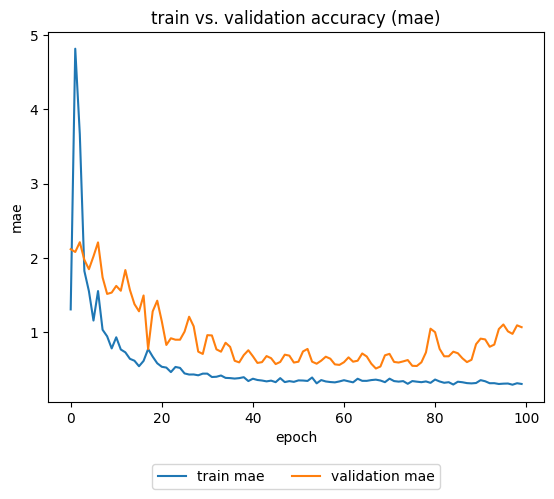

In [457]:
plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [458]:
train_pred_detrend = model.predict(X_input_train[:, :, :2])*x_train_max[:2]
test_pred_detrend = model.predict(X_input_test[:, :, :2])*x_train_max[:2]
print(train_pred_detrend.shape, test_pred_detrend.shape)
train_true_detrend = X_output_train[:, :, :2]*x_train_max[:2]
test_true_detrend = X_output_test[:, :, :2]*x_train_max[:2]
print(train_true_detrend.shape, test_true_detrend.shape)

1/1 [==============================] - 1s 561ms/step
(32, 30, 2) (19, 30, 2)
(32, 30, 2) (19, 30, 2)


In [459]:
train_pred_detrend = np.concatenate([train_pred_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_pred_detrend = np.concatenate([test_pred_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)
train_true_detrend = np.concatenate([train_true_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_true_detrend = np.concatenate([test_true_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

(32, 30, 3) (19, 30, 3)
(32, 30, 3) (19, 30, 3)


In [460]:
data_final = dict()
for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend], 
                  ['train_pred', 'train_true', 'test_pred', 'test_true']):
    dt_x1 = dt[:, :, 0] + (dt[:, :, 2]**2)*x1_trend_param[0] + dt[:, :, 2]*x1_trend_param[1] + x1_trend_param[2]
    dt_x2 = dt[:, :, 1] + dt[:, :, 2]*x2_trend_param[0] + x2_trend_param[1]
    data_final[lb] = np.concatenate(
        [np.expand_dims(dt_x1, axis=2), np.expand_dims(dt_x2, axis=2)], axis=2)
    print(lb+': {}'.format(data_final[lb].shape))

train_pred: (32, 30, 2)
train_true: (32, 30, 2)
test_pred: (19, 30, 2)
test_true: (19, 30, 2)


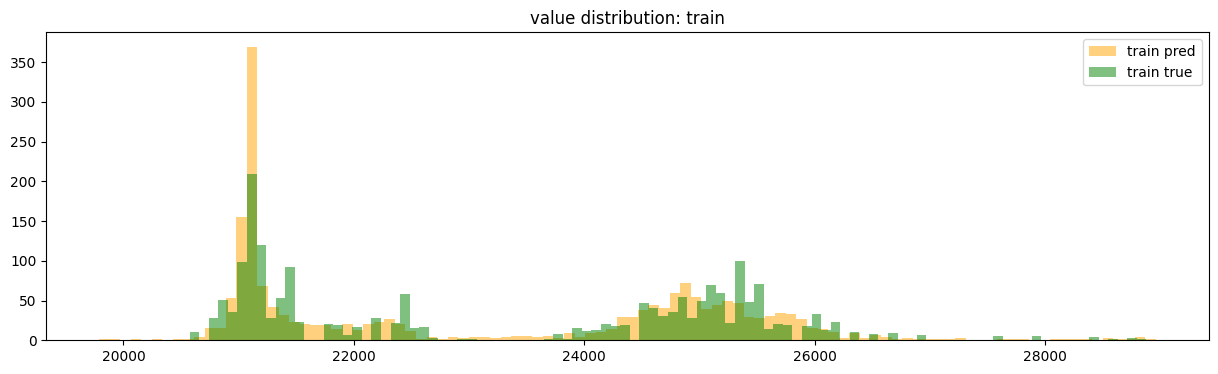

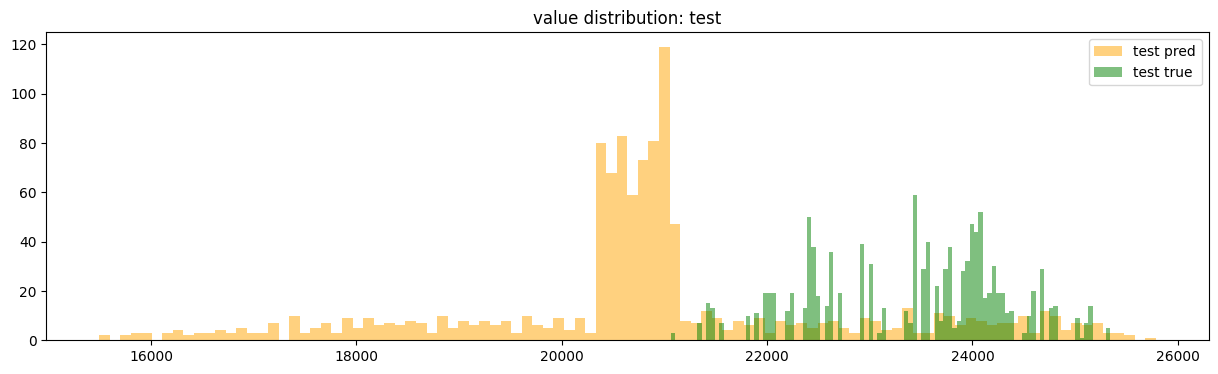

In [461]:
for lb in ['train', 'test']:
    plt.figure(figsize=(15, 4))
    plt.hist(data_final[lb+'_pred'].flatten(), bins=100, color='orange', alpha=0.5, label=lb+' pred')
    plt.hist(data_final[lb+'_true'].flatten(), bins=100, color='green', alpha=0.5, label=lb+' true')
    plt.legend()
    plt.title('value distribution: '+lb)
    plt.show()

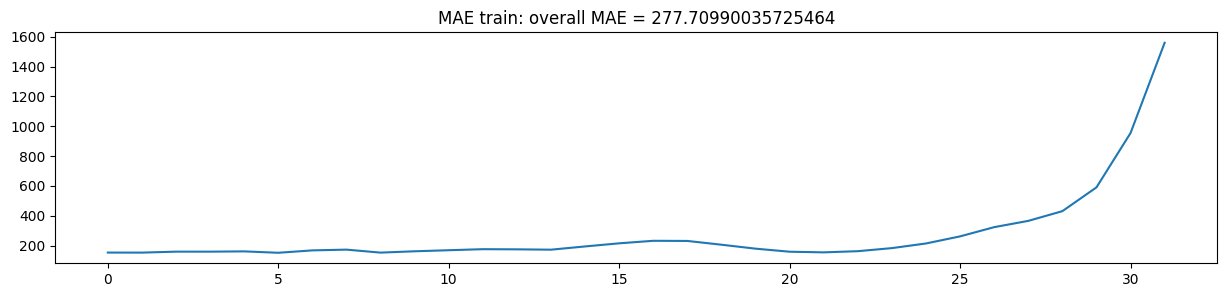

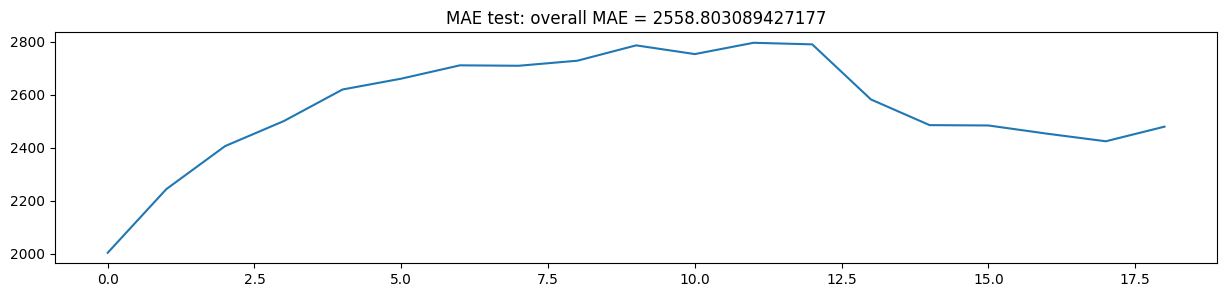

In [462]:
for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show()

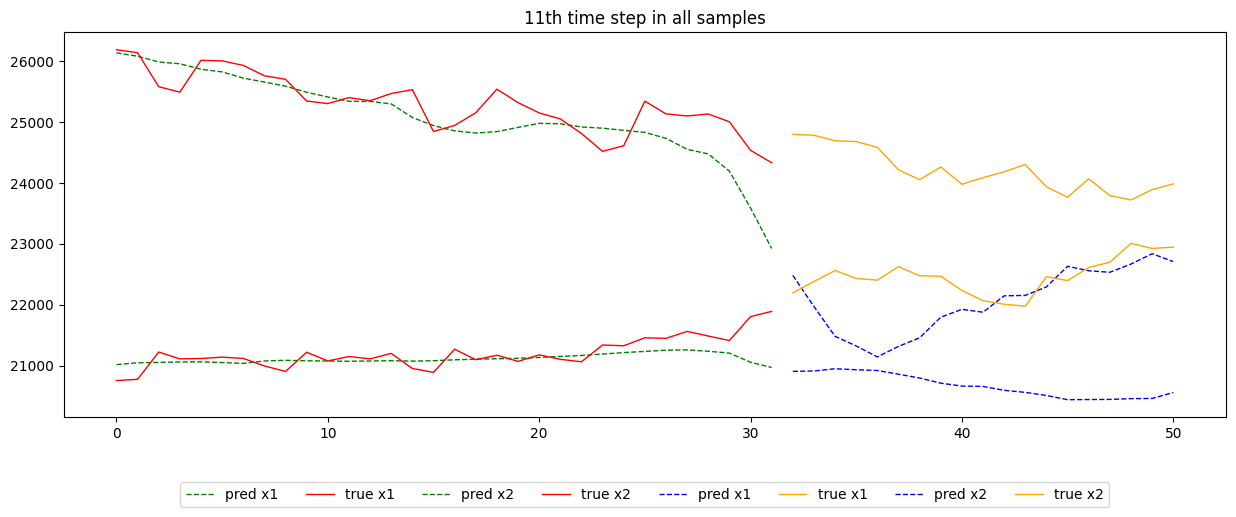

In [463]:
ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
plt.figure(figsize=(15, 5))
train_start_t = 0
test_start_t = data_final['train_pred'].shape[0]
for lb, tm, clrs in zip(['train', 'test'], [train_start_t, test_start_t], [['green', 'red'], ['blue', 'orange']]):
    for i, x_lbl in zip([0, 1], ['x1', 'x2']):
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_pred'][:, ith_timestep, i], 
                 linestyle='--', linewidth=1, color=clrs[0], label='pred '+x_lbl)
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_true'][:, ith_timestep, i], 
                 linestyle='-', linewidth=1, color=clrs[1], label='true '+x_lbl)
    
plt.title('{}th time step in all samples'.format(ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=8)
plt.show()

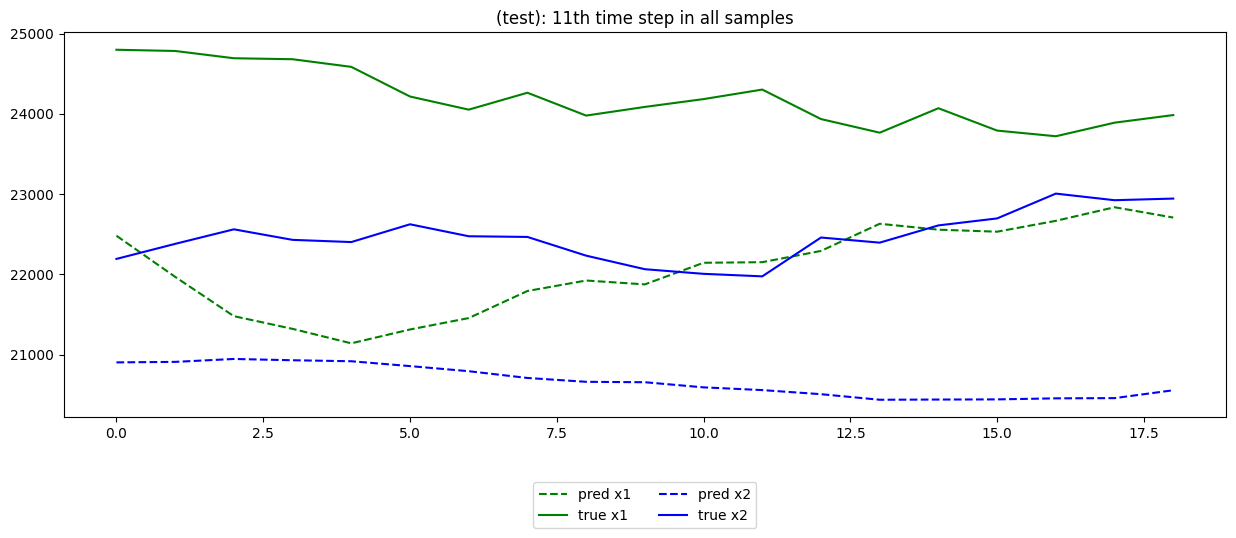

In [464]:
lb = 'test'
plt.figure(figsize=(15, 5))
for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
    plt.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='--', color=clr, label='pred '+x_lbl)
    plt.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
plt.title('({}): {}th time step in all samples'.format(lb, ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

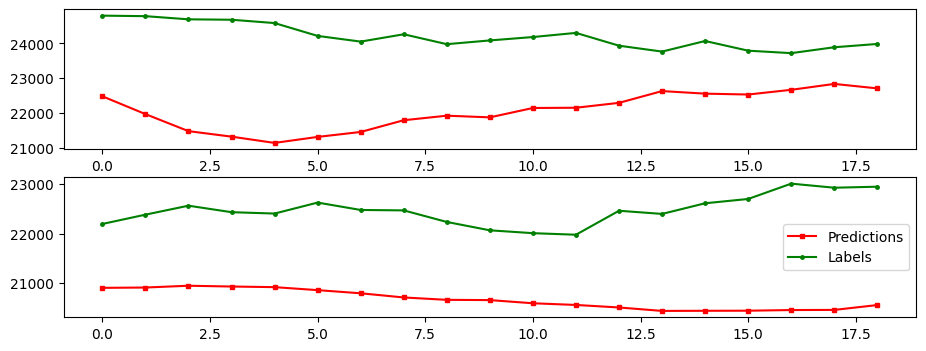

In [465]:
plt.figure(figsize=(11, 4))
plt.subplot(2, 1, 1)
plt.plot(data_final['test_pred'][:, ith_timestep, 0], color='red', label='Predictions', marker='s', ms=3)
plt.plot(data_final['test_true'][:, ith_timestep, 0], color='green', label='Labels', marker='.', ms=5)
plt.subplot(2, 1, 2)
plt.plot(data_final['test_pred'][:, ith_timestep, 1], color='red', label='Predictions', marker='s', ms=3)
plt.plot(data_final['test_true'][:, ith_timestep, 1], color='green', label='Labels', marker='.', ms=5)
plt.legend()
plt.show()

In [491]:
all_mae_ = {}
all_r2_ = {}

In [492]:
all_r2_['train_daily_1'] = history.history['coeff_determination'][-1]
all_r2_['val_daily_1'] = history.history['val_coeff_determination'][-1]
all_mae_['train_daily_1'] = history.history['mae'][-1]
all_mae_['val_daily_1'] = history.history['val_mae'][-1]

### GRU

In [468]:
encoder_last_h1, encoder_last_c = GRU(
 n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
 return_sequences=False, return_state=True)(input_train)
print(encoder_last_h1)
# print(encoder_last_h2)
print(encoder_last_c)

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='gru_15/strided_slice_3:0', description="created by layer 'gru_15'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='gru_15/while:4', description="created by layer 'gru_15'")


In [469]:
encoder_last_h1 = BatchNormalization(momentum=0.6)(encoder_last_h1)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

In [470]:
decoder = RepeatVector(output_train.shape[1])(encoder_last_h1)
decoder = GRU(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_state=False, return_sequences=True)(
    decoder, initial_state=encoder_last_c)
print(decoder)

KerasTensor(type_spec=TensorSpec(shape=(None, 30, 100), dtype=tf.float32, name=None), name='gru_16/transpose_1:0', description="created by layer 'gru_16'")


In [471]:
out = TimeDistributed(Dense(output_train.shape[2]))(decoder)
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 30, 2), dtype=tf.float32, name=None), name='time_distributed_12/Reshape_1:0', description="created by layer 'time_distributed_12'")


In [472]:
model_ = Model(inputs=input_train, outputs=out)
opt = Adam(learning_rate=0.01, clipnorm=1)
model_.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae', coeff_determination])
# model.summary()

In [473]:
epc = 100
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history_ = model_.fit(X_input_train[:, :, :2], X_output_train[:, :, :2], validation_split=0.2, 
                    epochs=epc, verbose=0, callbacks=[es], 
                    batch_size=100)
train_mae = history_.history['mae']
valid_mae = history_.history['val_mae']
 
# model.save('model_forecasting_seq2seq.h5')

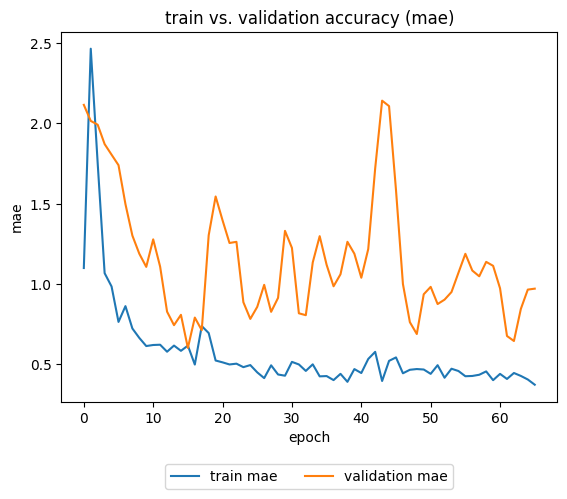

In [474]:
plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [475]:
train_pred_detrend = model.predict(X_input_train[:, :, :2])*x_train_max[:2]
test_pred_detrend = model.predict(X_input_test[:, :, :2])*x_train_max[:2]
print(train_pred_detrend.shape, test_pred_detrend.shape)
train_true_detrend = X_output_train[:, :, :2]*x_train_max[:2]
test_true_detrend = X_output_test[:, :, :2]*x_train_max[:2]
print(train_true_detrend.shape, test_true_detrend.shape)

1/1 [==============================] - 0s 47ms/step
(32, 30, 2) (19, 30, 2)
(32, 30, 2) (19, 30, 2)


In [476]:
train_pred_detrend = np.concatenate([train_pred_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_pred_detrend = np.concatenate([test_pred_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)
train_true_detrend = np.concatenate([train_true_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_true_detrend = np.concatenate([test_true_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

(32, 30, 3) (19, 30, 3)
(32, 30, 3) (19, 30, 3)


In [477]:
data_final = dict()
for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend], 
                  ['train_pred', 'train_true', 'test_pred', 'test_true']):
    dt_x1 = dt[:, :, 0] + (dt[:, :, 2]**2)*x1_trend_param[0] + dt[:, :, 2]*x1_trend_param[1] + x1_trend_param[2]
    dt_x2 = dt[:, :, 1] + dt[:, :, 2]*x2_trend_param[0] + x2_trend_param[1]
    data_final[lb] = np.concatenate(
        [np.expand_dims(dt_x1, axis=2), np.expand_dims(dt_x2, axis=2)], axis=2)
    print(lb+': {}'.format(data_final[lb].shape))

train_pred: (32, 30, 2)
train_true: (32, 30, 2)
test_pred: (19, 30, 2)
test_true: (19, 30, 2)


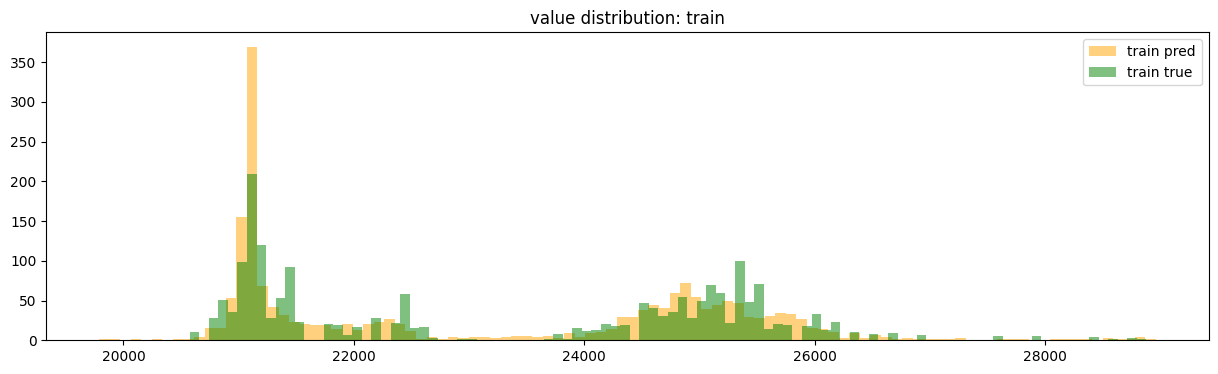

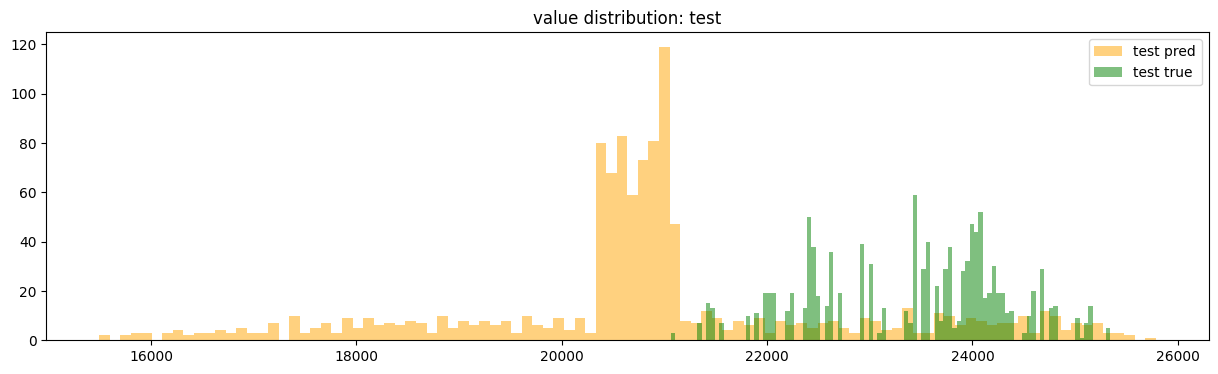

In [478]:
for lb in ['train', 'test']:
    plt.figure(figsize=(15, 4))
    plt.hist(data_final[lb+'_pred'].flatten(), bins=100, color='orange', alpha=0.5, label=lb+' pred')
    plt.hist(data_final[lb+'_true'].flatten(), bins=100, color='green', alpha=0.5, label=lb+' true')
    plt.legend()
    plt.title('value distribution: '+lb)
    plt.show()

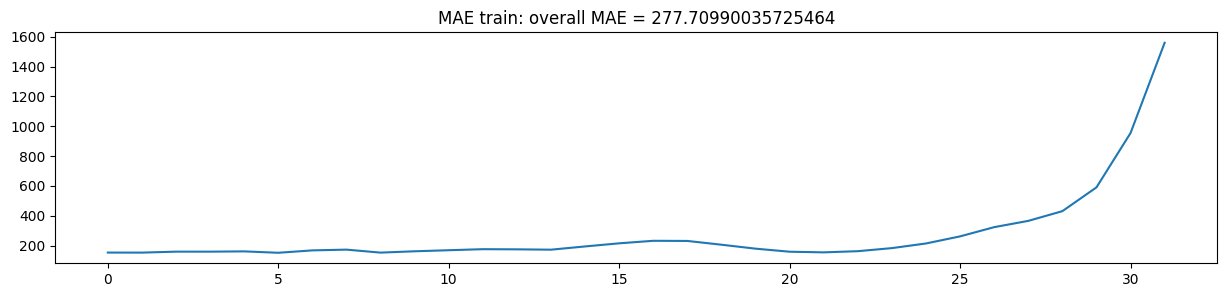

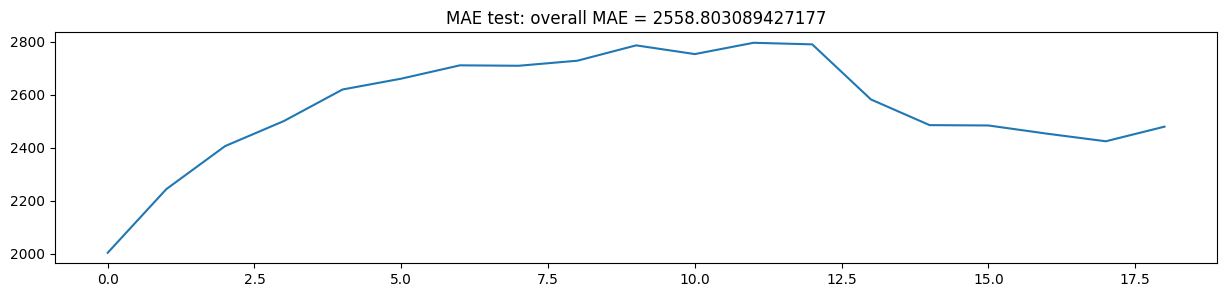

In [479]:
for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show()

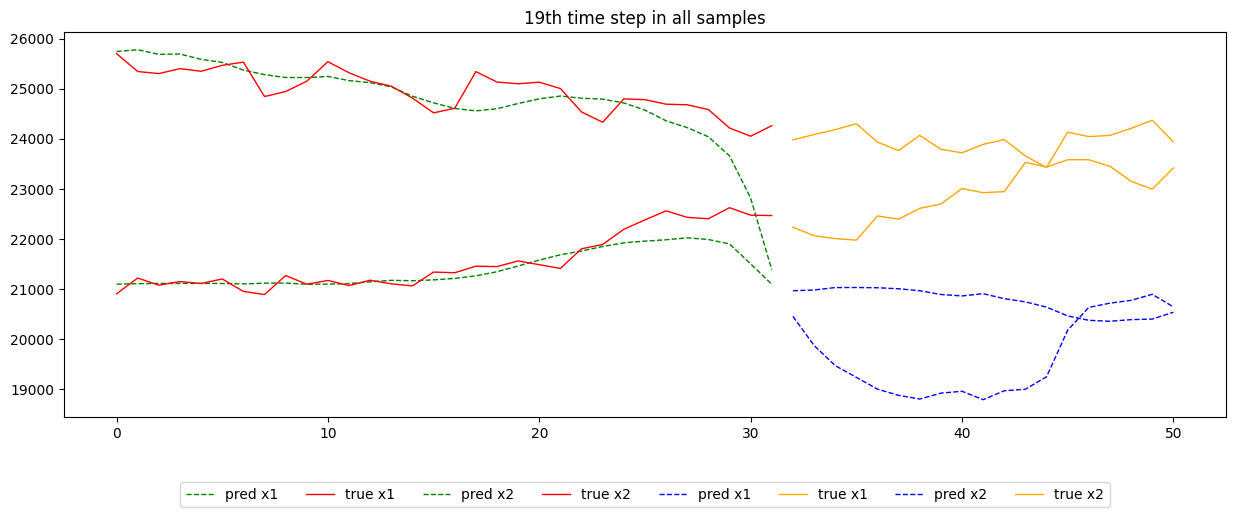

In [480]:
ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
plt.figure(figsize=(15, 5))
train_start_t = 0
test_start_t = data_final['train_pred'].shape[0]
for lb, tm, clrs in zip(['train', 'test'], [train_start_t, test_start_t], [['green', 'red'], ['blue', 'orange']]):
    for i, x_lbl in zip([0, 1], ['x1', 'x2']):
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_pred'][:, ith_timestep, i], 
                 linestyle='--', linewidth=1, color=clrs[0], label='pred '+x_lbl)
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_true'][:, ith_timestep, i], 
                 linestyle='-', linewidth=1, color=clrs[1], label='true '+x_lbl)
    
plt.title('{}th time step in all samples'.format(ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=8)
plt.show()

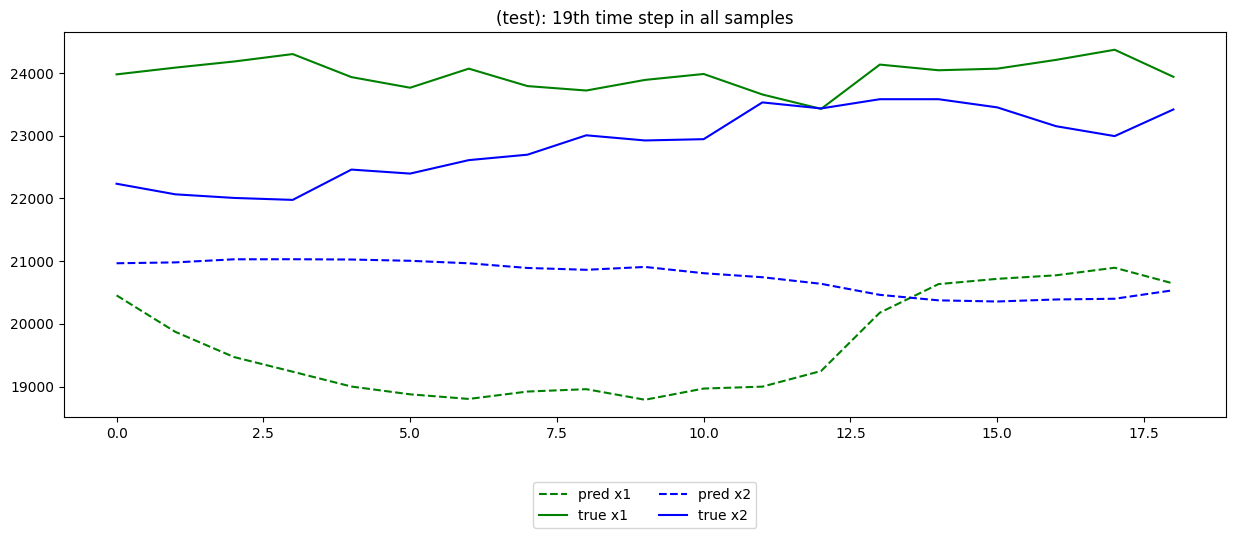

In [481]:
lb = 'test'
plt.figure(figsize=(15, 5))
for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
    plt.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='--', color=clr, label='pred '+x_lbl)
    plt.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
plt.title('({}): {}th time step in all samples'.format(lb, ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

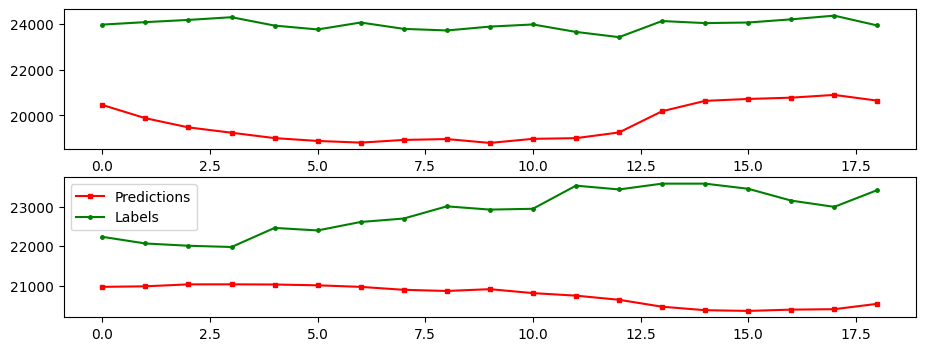

In [482]:
plt.figure(figsize=(11, 4))
plt.subplot(2, 1, 1)
plt.plot(data_final['test_pred'][:, ith_timestep, 0], color='red', label='Predictions', marker='s', ms=3)
plt.plot(data_final['test_true'][:, ith_timestep, 0], color='green', label='Labels', marker='.', ms=5)
plt.subplot(2, 1, 2)
plt.plot(data_final['test_pred'][:, ith_timestep, 1], color='red', label='Predictions', marker='s', ms=3)
plt.plot(data_final['test_true'][:, ith_timestep, 1], color='green', label='Labels', marker='.', ms=5)
plt.legend()
plt.show()

In [493]:
all_r2_['train_daily_2'] = history_.history['coeff_determination'][-1]
all_r2_['val_daily_2'] = history_.history['val_coeff_determination'][-1]
all_mae_['train_daily_2'] = history_.history['mae'][-1]
all_mae_['val_daily_2'] = history_.history['val_mae'][-1]

### Сравнение

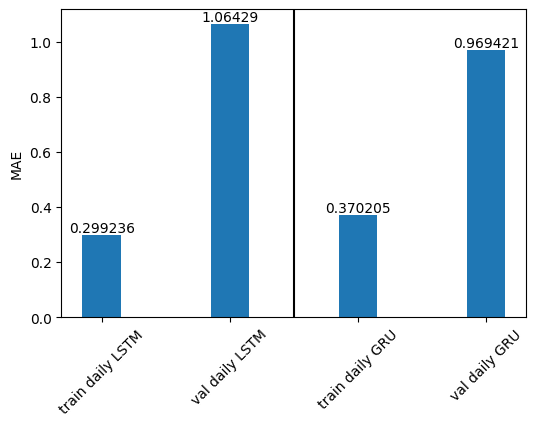

In [494]:
x = np.arange(len(all_mae_))
width = 0.3
y = all_mae_.values()
labels = [i.replace('_', ' ').replace('1', 'LSTM').replace('2', 'GRU') for i in all_mae_.keys()]

plt.figure(figsize=(6, 4))
bar1 = plt.bar(x, y, width)
plt.bar_label(bar1)
plt.xticks(ticks=x, labels=labels, rotation=45)
plt.ylabel(f'MAE')
plt.axvline(x=1.5, color='black')
plt.show()

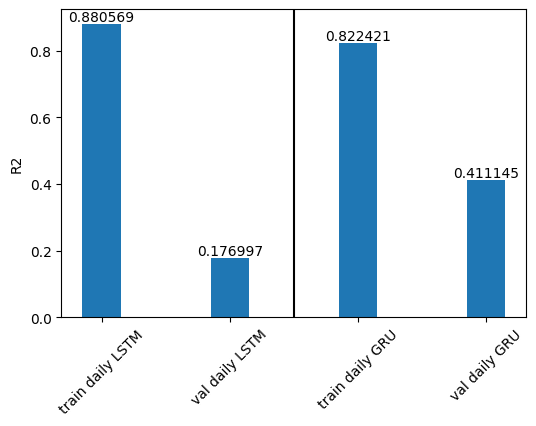

In [495]:
x = np.arange(len(all_r2_))
width = 0.3
y = all_r2_.values()
labels = [i.replace('_', ' ').replace('1', 'LSTM').replace('2', 'GRU') for i in all_r2_.keys()]

plt.figure(figsize=(6, 4))
bar1 = plt.bar(x, y, width)
plt.bar_label(bar1)
plt.xticks(ticks=x, labels=labels, rotation=45)
plt.ylabel(f'R2')
plt.axvline(x=1.5, color='black')
plt.show()

In [496]:
all_r2

{'train_hourly_1': 0.9069184064865112,
 'val_hourly_1': 0.834484338760376,
 'train_hourly_2': 0.8224208354949951,
 'val_hourly_2': 0.4111453890800476,
 'train_daily_2': 0.8224208354949951,
 'val_daily_2': 0.4111453890800476}